+----------+-----------+----------------------+---------------+------------+-----------------------+----------------+
|      date|    country|cumulative_total_cases|daily_new_cases|active_cases|cumulative_total_deaths|daily_new_deaths|
+----------+-----------+----------------------+---------------+------------+-----------------------+----------------+
|2020-02-15|Afghanistan|                     0|           NULL|           0|                      0|            NULL|
|2020-02-16|Afghanistan|                     0|           NULL|           0|                      0|            NULL|
|2020-02-17|Afghanistan|                     0|           NULL|           0|                      0|            NULL|
|2020-02-18|Afghanistan|                     0|           NULL|           0|                      0|            NULL|
|2020-02-19|Afghanistan|                     0|           NULL|           0|                      0|            NULL|
+----------+-----------+----------------------+---------

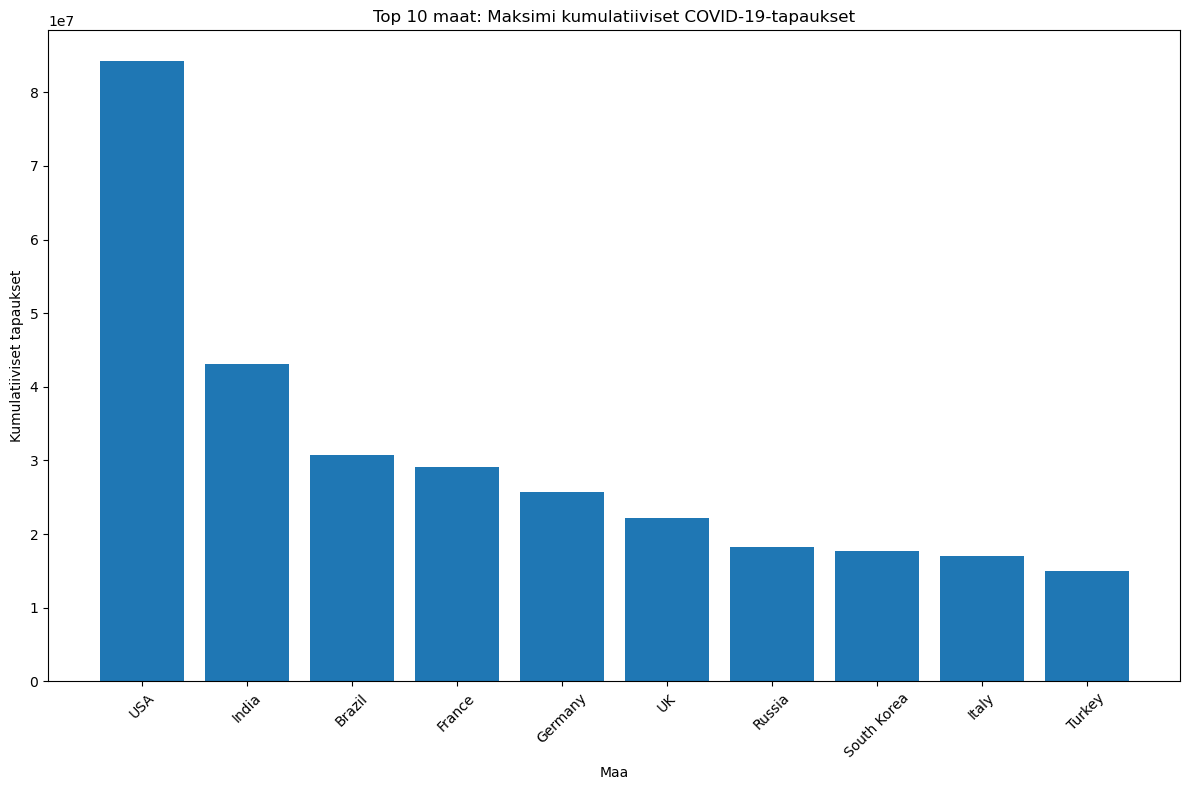

+-----+-----------------+
|month|monthly_new_cases|
+-----+-----------------+
|    1|        109494568|
|    2|         69274443|
|    3|         65416913|
|    4|         49712080|
|    5|         30216742|
|    6|         15982338|
|    7|         23178397|
|    8|         28275952|
|    9|         24766564|
|   10|         25360627|
|   11|         32995528|
|   12|         46156971|
+-----+-----------------+



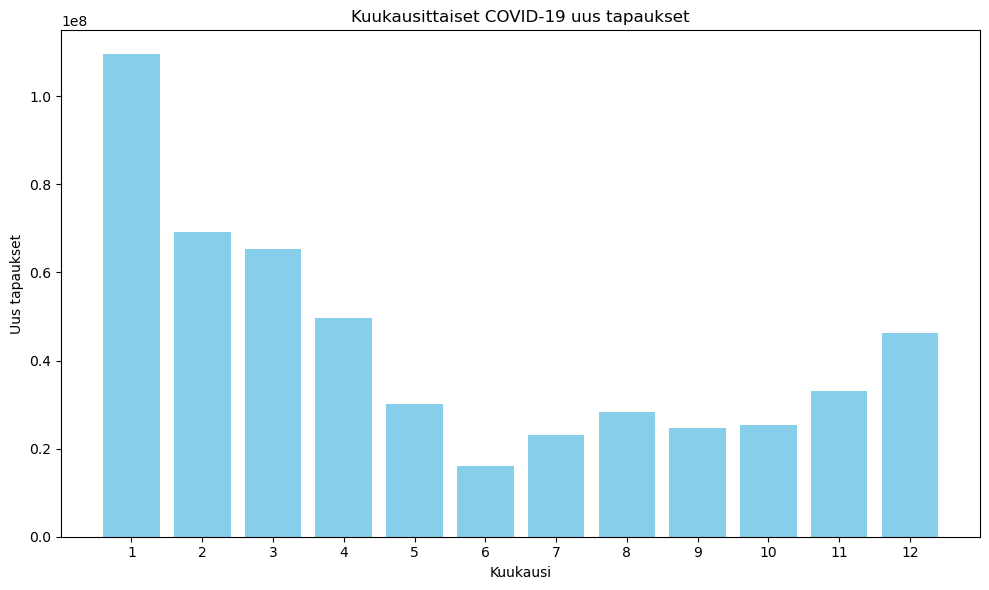

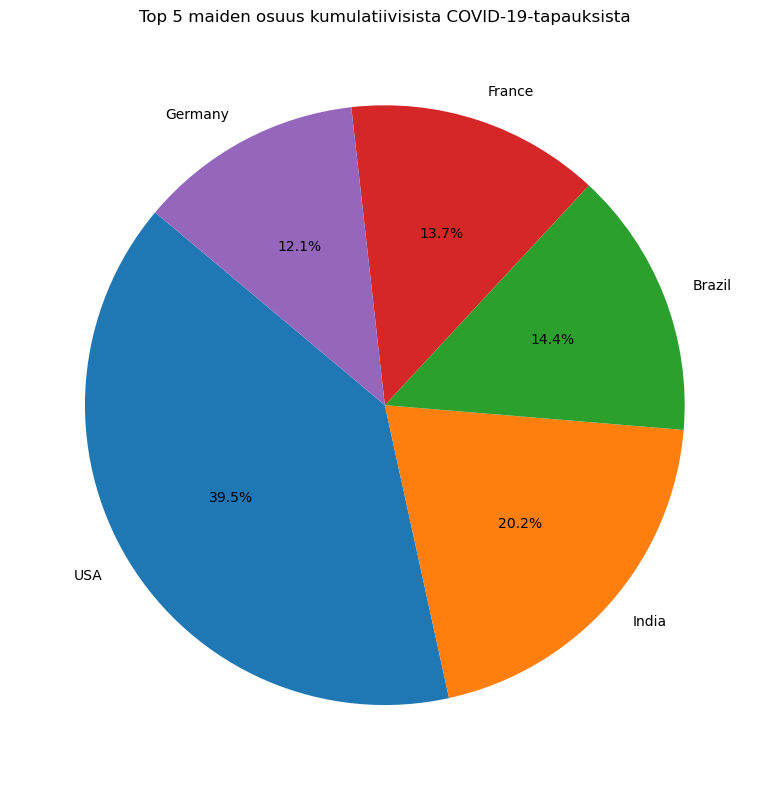

In [5]:
# -*- coding: utf-8 -*-
"""
COVID-19 Data Analysis: Monimaan dataa eri maista
Analysoidaan olennaiset tunnusluvut ja esitetään ne selkeinä taulukoina ja graafeina.
"""

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max as spark_max, sum as spark_sum, to_date, month
import matplotlib.pyplot as plt
import pandas as pd

# 1. Luo Spark-istunto
spark = SparkSession.builder.appName("CovidDataAnalysisMultiCountry").getOrCreate()

# 2. Lue CSV-tiedosto (oletuksena tiedoston nimi on "Covid19.csv")
df = spark.read.option("header", "true").csv("Covid19.csv")

# 3. Esikäsittele data:
#    - Muunna 'date'-sarake datetime-tyyppiseksi
#    - Muunna numeeriset sarakkeet kokonaisluvuiksi
df = df.withColumn("date", to_date(col("date"), "yyyy-M-d")) \
       .withColumn("cumulative_total_cases", col("cumulative_total_cases").cast("int")) \
       .withColumn("daily_new_cases", col("daily_new_cases").cast("int")) \
       .withColumn("active_cases", col("active_cases").cast("int")) \
       .withColumn("cumulative_total_deaths", col("cumulative_total_deaths").cast("int")) \
       .withColumn("daily_new_deaths", col("daily_new_deaths").cast("int"))

# Näytetään muutama rivi raakadataa
df.show(5)

# -------------------------------
# Aggregointi maan mukaan (jo aiemmin tehty)
df_summary = df.groupBy("country").agg(
    spark_max("cumulative_total_cases").alias("max_cumulative_total_cases"),
    spark_sum("daily_new_cases").alias("total_daily_new_cases"),
    spark_max("active_cases").alias("max_active_cases"),
    spark_max("cumulative_total_deaths").alias("max_cumulative_total_deaths"),
    spark_sum("daily_new_deaths").alias("total_daily_new_deaths")
)
df_summary.show()

pdf_summary = df_summary.toPandas()
pdf_summary.sort_values("max_cumulative_total_cases", ascending=False, inplace=True)
print("Yhteenvetotaulukko eri maista:")
print(pdf_summary)

# Visualisointi: Top 10 maat maksimaalisilla kumulatiivisilla tapauksilla
top10 = pdf_summary.head(10)
plt.figure(figsize=(12, 8))
plt.bar(top10["country"], top10["max_cumulative_total_cases"])
plt.title("Top 10 maat: Maksimi kumulatiiviset COVID-19-tapaukset")
plt.xlabel("Maa")
plt.ylabel("Kumulatiiviset tapaukset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("top10_cumulative_cases.png")
plt.show()

# -------------------------------
# Uusi kuvaaja 1: Kuukausittaiset tartunnat

# Lisää uusi sarake "month" päivämäärästä
df_with_month = df.withColumn("month", month(col("date")))

# Aggregoi kuukausittaiset uudet tapaukset
df_monthly = df_with_month.groupBy("month").agg(
    spark_sum("daily_new_cases").alias("monthly_new_cases")
).orderBy("month")
df_monthly.show()

# Muunna kuukausidata Pandas DataFrameksi ja piirrä pylväsdiagrammi
pdf_monthly = df_monthly.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(pdf_monthly["month"].astype(str), pdf_monthly["monthly_new_cases"], color='skyblue')
plt.title("Kuukausittaiset COVID-19 uus tapaukset")
plt.xlabel("Kuukausi")
plt.ylabel("Uus tapaukset")
plt.tight_layout()
plt.savefig("monthly_new_cases.png")
plt.show()

# -------------------------------
# Uusi kuvaaja 2: Top 5 maiden osuus kumulatiivisista tapauksista (piirakkadiagrammi)

# Valitaan Top 5 maata
top5 = pdf_summary.head(5)
labels = top5["country"]
sizes = top5["max_cumulative_total_cases"]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Top 5 maiden osuus kumulatiivisista COVID-19-tapauksista")
plt.tight_layout()
plt.savefig("top5_pie_chart.png")
plt.show()

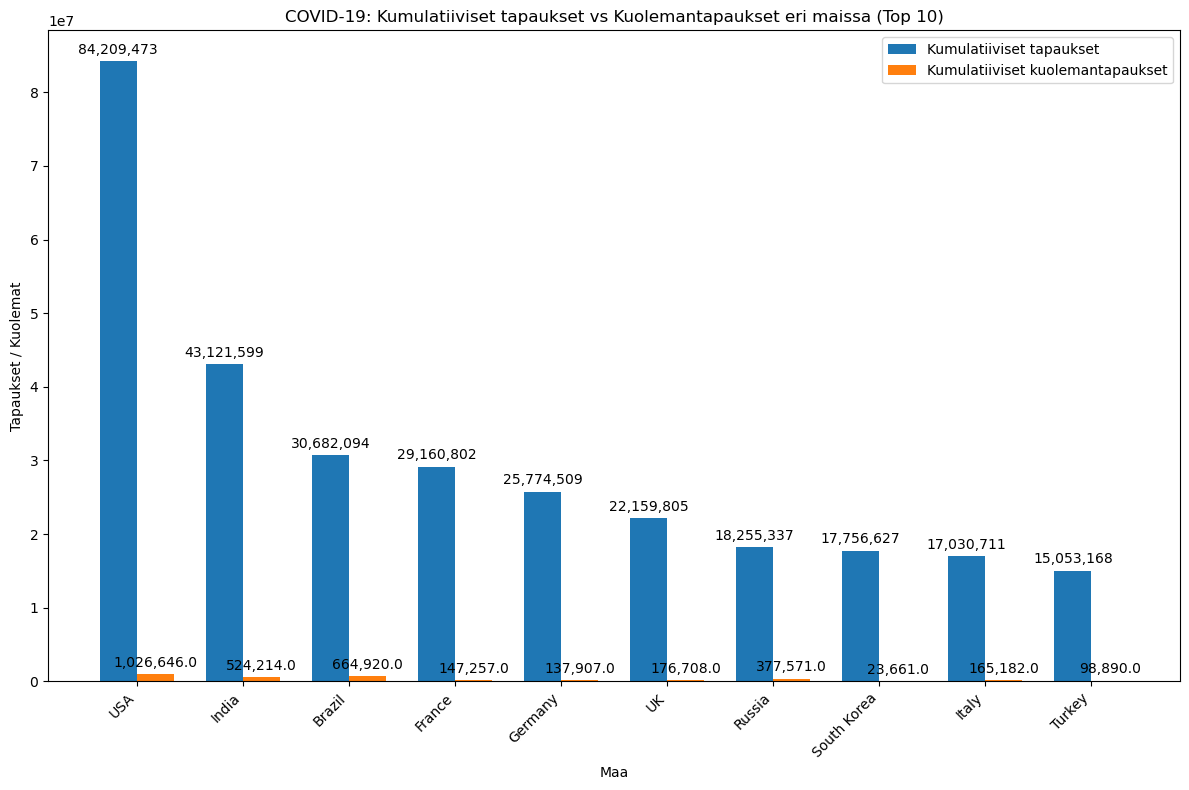

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Suodatetaan maat, joissa on raportoitu tapauksia, ja lajitellaan
countries_data = pdf_summary[pdf_summary["max_cumulative_total_cases"] > 0].sort_values("max_cumulative_total_cases", ascending=False)
top_countries = countries_data.head(10)

# Määritellään x-akselin sijainnit ja pylväiden leveys
N = len(top_countries)
ind = np.arange(N)  # ryhmien sijainnit x-akselilla
width = 0.35       # pylväiden leveys

fig, ax = plt.subplots(figsize=(12, 8))

# Piirretään pylväät kummallekin tunnusluvulle
bars_cases = ax.bar(ind - width/2, top_countries["max_cumulative_total_cases"], width, label='Kumulatiiviset tapaukset')
bars_deaths = ax.bar(ind + width/2, top_countries["max_cumulative_total_deaths"], width, label='Kumulatiiviset kuolemantapaukset')

# Asetetaan otsikko, x- ja y-akselien nimet
ax.set_title('COVID-19: Kumulatiiviset tapaukset vs Kuolemantapaukset eri maissa (Top 10)')
ax.set_xlabel('Maa')
ax.set_ylabel('Tapaukset / Kuolemat')
ax.set_xticks(ind)
ax.set_xticklabels(top_countries["country"], rotation=45, ha='right')
ax.legend()

# Lisätään arvojen näyttäminen pylväiden päälle
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # pieni siirto pystysuunnassa
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars_cases)
autolabel(bars_deaths)

plt.tight_layout()
plt.savefig("cases_vs_deaths_by_country.png")
plt.show()

+----------+---------------------+
|      date|total_daily_new_cases|
+----------+---------------------+
|2020-01-22|                 NULL|
|2020-01-23|                  259|
|2020-01-24|                  457|
|2020-01-25|                  688|
|2020-01-26|                  769|
|2020-01-27|                 1771|
|2020-01-28|                 1459|
|2020-01-29|                 1737|
|2020-01-30|                 1981|
|2020-01-31|                 2099|
|2020-02-01|                 2589|
|2020-02-02|                 2825|
|2020-02-03|                 3235|
|2020-02-04|                 3884|
|2020-02-05|                 3694|
|2020-02-06|                 3143|
|2020-02-07|                 3385|
|2020-02-08|                 2652|
|2020-02-09|                 2973|
|2020-02-10|                 2467|
+----------+---------------------+
only showing top 20 rows



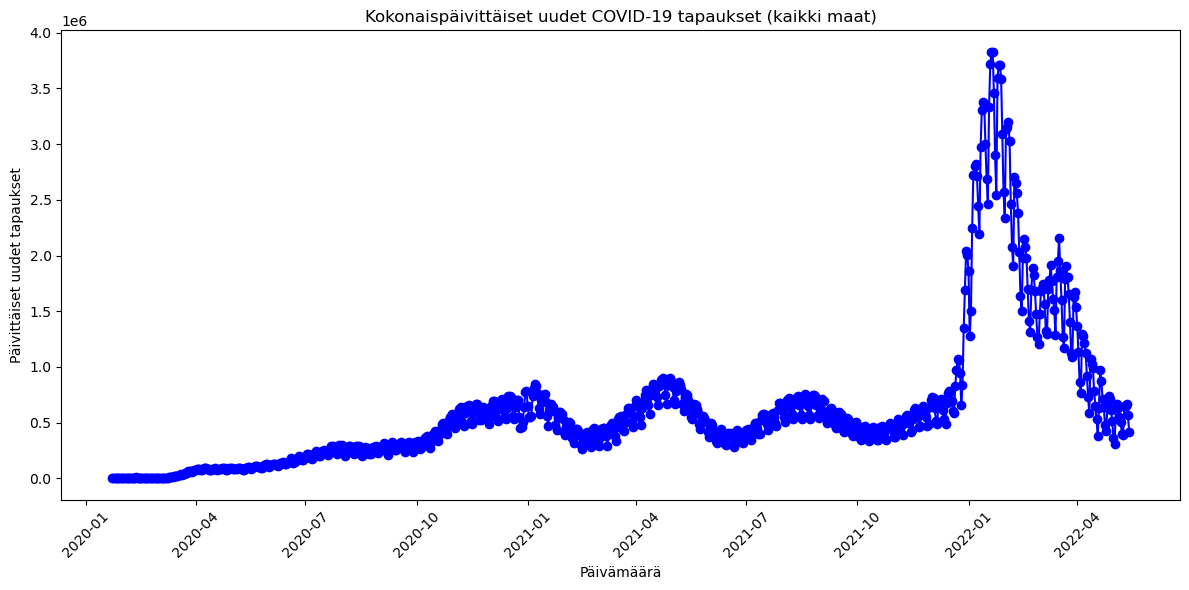

Top 5 maat: ['USA', 'India', 'Brazil', 'France', 'Germany']
+----------+-------+---------------+
|      date|country|daily_new_cases|
+----------+-------+---------------+
|2020-02-15|Germany|           NULL|
|2020-02-15| Brazil|           NULL|
|2020-02-15|  India|           NULL|
|2020-02-15| France|           NULL|
|2020-02-15|    USA|           NULL|
|2020-02-16|Germany|              0|
|2020-02-16| France|              0|
|2020-02-16|  India|              0|
|2020-02-16| Brazil|           NULL|
|2020-02-16|    USA|              0|
|2020-02-17|Germany|              0|
|2020-02-17| Brazil|           NULL|
|2020-02-17|  India|              0|
|2020-02-17| France|              0|
|2020-02-17|    USA|              0|
|2020-02-18|  India|              0|
|2020-02-18|Germany|              0|
|2020-02-18| Brazil|           NULL|
|2020-02-18| France|              0|
|2020-02-18|    USA|              0|
+----------+-------+---------------+
only showing top 20 rows



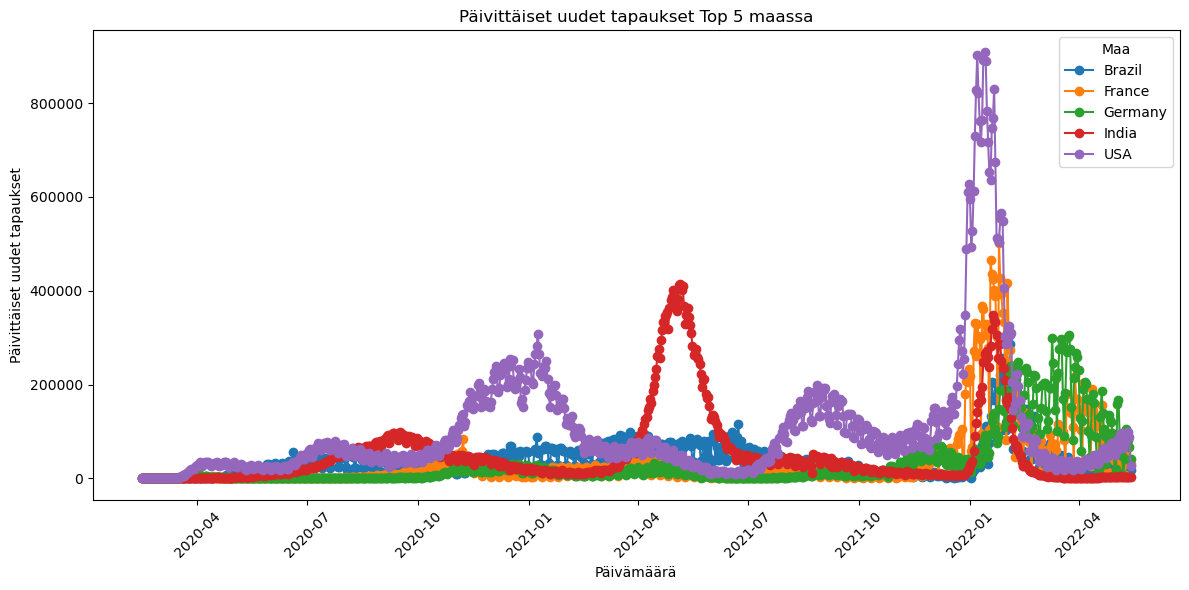

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import sum as spark_sum, to_date

# -------------------------------
# Kuvaaja 1: Total Daily New Cases (kaikkien maiden yhteenlaskettu päivittäinen uusi tapaus)
# Aggregoidaan data päivämäärän mukaan, summataan "daily_new_cases" kaikilta mailta

df_daily = df.groupBy("date").agg(
    spark_sum("daily_new_cases").alias("total_daily_new_cases")
).orderBy("date")
df_daily.show()

# Muunnetaan aggregoitu data Pandas DataFrameksi
pdf_daily = df_daily.toPandas()
pdf_daily.sort_values("date", inplace=True)

# Piirretään viivakuvio
plt.figure(figsize=(12, 6))
plt.plot(pdf_daily["date"], pdf_daily["total_daily_new_cases"], marker="o", linestyle="-", color='b')
plt.title("Kokonaispäivittäiset uudet COVID-19 tapaukset (kaikki maat)")
plt.xlabel("Päivämäärä")
plt.ylabel("Päivittäiset uudet tapaukset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("total_daily_new_cases.png")
plt.show()

# -------------------------------
# Kuvaaja 2: Daily New Cases by Top 5 Countries
# Valitaan Top 5 maata kumulatiivisten tapausten perusteella
top5_countries = pdf_summary[pdf_summary["max_cumulative_total_cases"] > 0].head(5)["country"].tolist()
print("Top 5 maat:", top5_countries)

# Suodatetaan alkuperäisestä datasta vain Top 5 maat
df_top5 = df.filter(df["country"].isin(top5_countries))

# Aggregoidaan päivittäiset uudet tapaukset kullekin top5-maalle erikseen
df_top5_daily = df_top5.groupBy("date", "country").agg(
    spark_sum("daily_new_cases").alias("daily_new_cases")
).orderBy("date")
df_top5_daily.show()

# Muunnetaan Pandas DataFrameksi
pdf_top5_daily = df_top5_daily.toPandas()
pdf_top5_daily["date"] = pd.to_datetime(pdf_top5_daily["date"])
pdf_top5_daily.sort_values("date", inplace=True)

# Pivot-taulukon avulla saadaan data muodosta, jossa päivämäärä on index, ja sarakkeina top5-maat
pdf_pivot = pdf_top5_daily.pivot(index="date", columns="country", values="daily_new_cases")
pdf_pivot = pdf_pivot.fillna(0)  # täytetään mahdolliset puuttuvat arvot nollilla

# Piirretään usean viivan kuvaaja
plt.figure(figsize=(12, 6))
for country in pdf_pivot.columns:
    plt.plot(pdf_pivot.index, pdf_pivot[country], marker="o", linestyle="-", label=country)
plt.title("Päivittäiset uudet tapaukset Top 5 maassa")
plt.xlabel("Päivämäärä")
plt.ylabel("Päivittäiset uudet tapaukset")
plt.legend(title="Maa")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("top5_daily_new_cases.png")
plt.show()